# Data exploration & preprocessing with Titanic dataset

<p style='text-align: right;'> written by Youngsoo Kim </p>

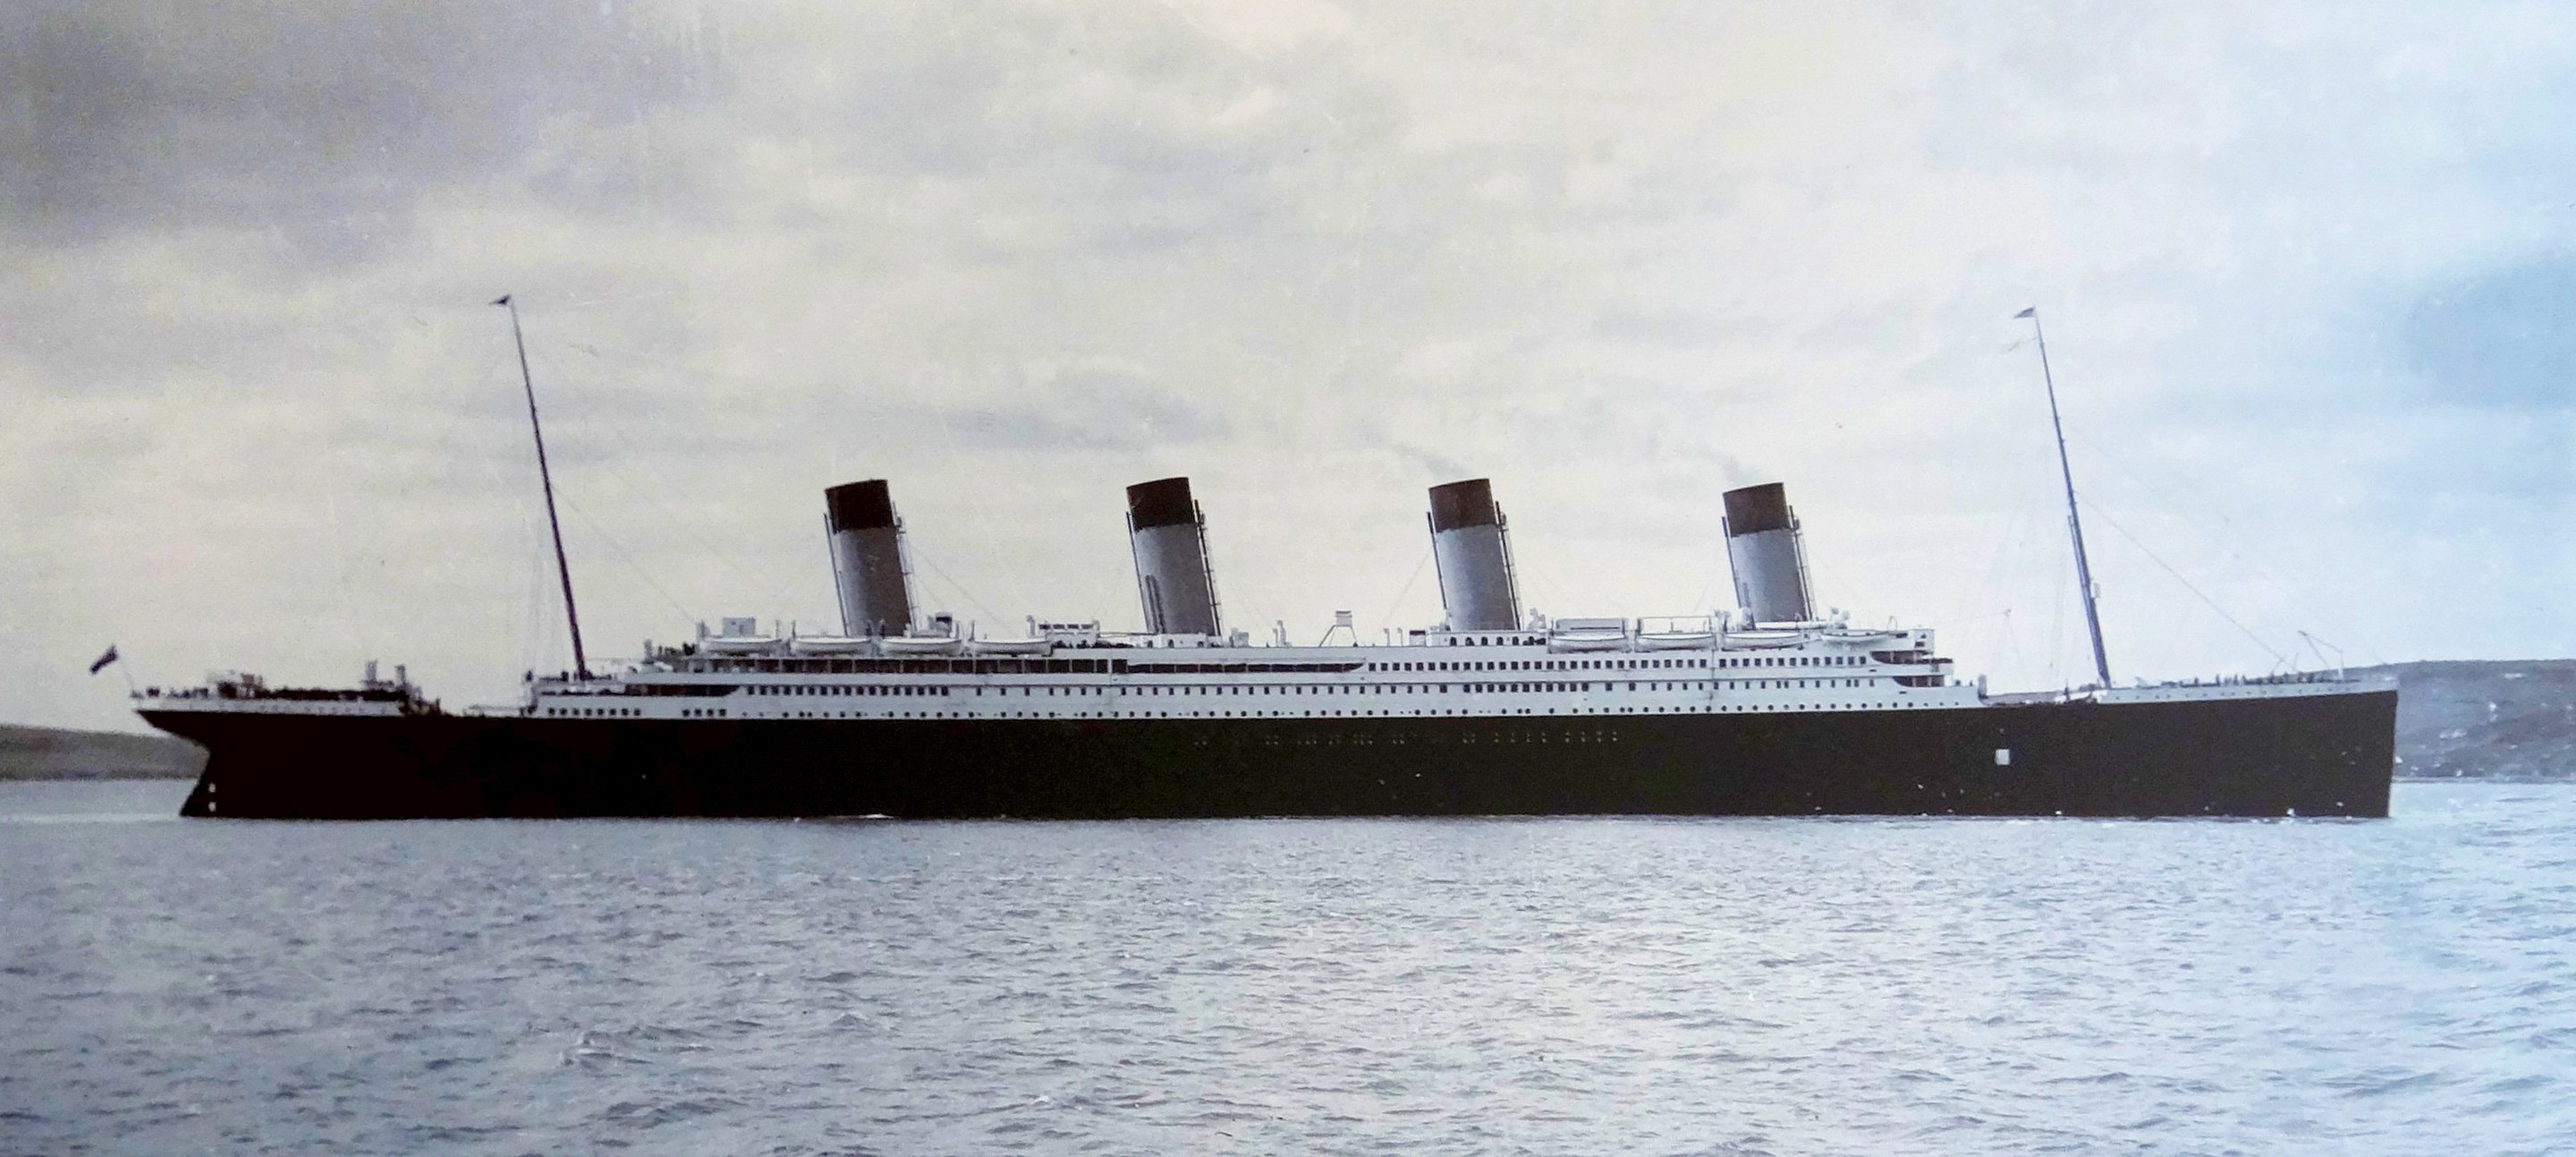

<img src="./pictures/titanic_structure.png" width="60%">

<img src="./pictures/titanic_map.png">

* 발생일시 : 1912년 4월 14일 오후 11시 40분 - 4월 15일 오전 2시 20분
* 탑승인원/사망인원/생존인원 : 2224명 / 1514명 / 710명 

In [ ]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# 데이터셋 불러오기
raw_data = pd.read_csv('./dataset/titanic_train.csv')
raw_data.head()

### 1. Variable identification

In [ ]:
# pandas의 info함수를 이용한 데이터셋에 대한 기본정보 알아보기
raw_data.info()

In [ ]:
#pandas의 describe함수를 이용한 데이터의 기본적인 통계값 살펴보기
raw_data.describe()

### 2. 1st data cleaning

In [ ]:
# data cleaning 작업을 위해 별도 작업용 데이터 복사
working_data = raw_data.copy(deep=True)     

#### 2.1 Fill missing values(NaN)

In [ ]:
# 결측값이 있는 데이터의 칼럼 조사
print(working_data.isnull().sum())

#### 2.1.1 Age, Fare, Embarked

In [ ]:
#Age 결측치를 중위값으로 채우기
working_data['age'].fillna(working_data['age'].median(), inplace=True)
#Fare 결측치는 해당 객실클래스의 평균값으로 채우기 
working_data['fare'].fillna(working_data.loc[working_data["pclass"]]['fare'].mean(), inplace=True)
#Embarked 결측치를 최빈값으로 채우기
working_data['embarked'].fillna(working_data['embarked'].mode()[0], inplace=True) 
# print(working_data.isnull().sum())

##### 2.1.2 Cabin

In [ ]:
# 객실 정보(cabin)가 없으나, 티켓번호(ticket)가 같은 사람 중 객실 정보가 있을 경우, 근처나 동일한 객실을 쓸 확률이 높으므로 객실 정보를 동일하게 변환
def search_cabin(given_ticket):
    for a in range(len(working_data.index)):
        if working_data['ticket'][a] == given_ticket and not working_data['cabin'].isna()[a]:
            return_cabin = working_data['cabin'][a]
            return return_cabin;
    return None;

cnt3 = 0;
for i in range(len(working_data.index)):
    if working_data['cabin'].isna()[i]:
        returned_cabin = search_cabin(working_data['ticket'][i]);
        if returned_cabin != None:
            working_data.cabin.iloc[i] = returned_cabin
            cnt3 = cnt3 + 1;

print("=> 객실 정보가 없을 시 같은 티켓번호를 갖고 있는 사람의 객실정보로  ", cnt3, "개 채워짐!")

☞  위와 같이 처리한 후에도 cabin는 너무 많은 결측값(998개)이 존재한다.  
☞  추후 다른 칼럼 값의 검증을 위한 보조데이터로 사용한 후 drop하기로 결정하여 추가적인 처리는 하지 않는다.

##### 2.1.3 boat, body, home.dest

In [ ]:
# 결측값 현황 확인
print(working_data.isnull().sum())

☞ boat, body, home.dest은 너무 많은 결측값(각각 823, 1188, 564)이 존재하고 boat와 body는 survived 결과에 따른 값이다.  
☞ 추후 다른 칼럼 값의 검증을 위한 보조데이터로 사용한 후, drop하기로 결정하여 추가적인 처리는 하지 않는다.

#### 2.2 Correct incorrect values

In [ ]:
# 구명보트(boat)의 번호가 있고  survived=0 인경우 survived=1로 조정
cnt1 = 0;
for i in range(len(working_data.index)):
    if not working_data['boat'].isna()[i] and working_data['survived'][i] ==0:
        working_data.survived.iloc[i] = 1;
        cnt1 = cnt1 + 1;
print("=> 구명보트와 survived의 관계를 통해 ", cnt1, "개 조정됨!")

#### 2.3 Numerize & Categorize(discretize) data

In [ ]:
# 나이(age) 범주화
bins = [0, 6, 12 ,20, 45, 65, 100]
working_data.age = pd.cut(working_data.age,bins,labels=['baby','child','teenager','adult','middle-aged','old'])

In [ ]:
# 신분(title) 범주화

## 이름으로부터  title 추출하여 title이라는 칼럼 추가
working_data['title'] = working_data['name'].str.extract('([A-Za-z]+)\.', expand=False)

## 잡다한 title을 대표 title 값으로 범주화하자.
working_data['title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr', 'Mr'],inplace=True)      # Master, Rev와 같은 title은 향후 나이 예측을 위해 남겨둔다.

## 각 title별 값을 수치화
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rev": 4}
working_data['title'] = working_data['title'].map(title_mapping)

In [ ]:
# 요금(fare) 범주화
##fare_bins = [0, 5, 10 ,15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 1000]
fare_bins = [0, 20, 40, 60, 80, 100, 200, 500, 1000]
working_data['fare_cat'] = pd.cut(working_data.fare, fare_bins)

In [ ]:
working_data.head(20)

### 3. Univariate Analysis

#### 3.1 Survived

In [ ]:
# 생존률을 pie 그래프로, 생존인원수를 bar 그래프로 나타내보자.
f,ax=plt.subplots(1,2,figsize=(12,6))

working_data['survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%', ax=ax[0], labels=['dead', 'survived'])
ax[0].set_title('Percentage of survived or not')
ax[0].set_ylabel('')

sns.countplot('survived',data=working_data,ax=ax[1])
sns.set(style="darkgrid")
ax[1].set_title('Count of survived or not')
plt.show()

#### 3.2 Pclass

In [ ]:
#각 객실등급별 탑승인원 수
sns.countplot(x="pclass", data=working_data)
plt.title("The number of passengers per class")
plt.show()

In [ ]:
# 각 클래스별 생존률
working_data.groupby('pclass').mean()['survived'].plot.bar()
plt.title("The number of passengers per class")
plt.show()

☞ 객실등급은 생존율에 영향을 미친다.

#### 3.3 Name (Title)

In [ ]:
# Title별로 생존률의 차이를 알아보자.
working_data.groupby('title').mean()['survived'].plot.bar()
plt.show()

* 0 : "Mr", 1 : "Miss", 2 : "Mrs", 3 : "Master", 4 : "Rev"    

#### 3.4 Sex

In [ ]:
# 성별 생존률의 차이를 알아보자.
working_data.groupby('sex').mean()['survived'].plot.bar()
plt.show()

#### 3.5 Age

In [ ]:
# 나이별로 생존률의 차이를 알아보자.
working_data.groupby('age').mean()['survived'].plot.bar()
plt.show()

In [ ]:
# 나이별 생존/사망자수를 stack bar로 알아보자.
figure = plt.figure(figsize=(10,5))
plt.hist([working_data[working_data['survived']==0]['age'], working_data[working_data['survived']==1]['age']], 
         stacked=True, color = ['r', 'g'], 
         bins = 11, label = ['Dead', 'Survived'],)
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()
plt.title('Survival by Age')
plt.show()

#### 3.6 Sibsp

In [ ]:
# 형제/배우자 수별로 생존률의 차이를 알아보자.
working_data.groupby('sibsp').mean()['survived'].plot.bar()
plt.show()

#### 3.7 Parch

In [ ]:
# 부모/자식 수별로 생존률의 차이를 알아보자.
working_data.groupby('parch').mean()['survived'].plot.bar()
plt.show()

#### 3.8 Fare

In [ ]:
# 먼저, 요금 차이별로 인원수를 살펴보자.
working_data.groupby('fare_cat').count()['name'].plot.bar()
plt.show()

In [ ]:
# 요금 차이별로 생존률의 차이를 알아보자.
working_data.groupby('fare_cat').mean()['survived'].plot.bar()
plt.show()

#### 3.9 Statistical information of dataset

In [ ]:
working_data.describe()

### 4. 2nd data cleaning

#### 4.1 Remove outliers

In [ ]:
# 변수별 Outlier 체크

plt.figure(figsize=(10,3))

plt.subplot(1, 4, 1); sns.boxplot(x=working_data['survived'], orient="v"); plt.xlabel('survivied'); plt.ylabel('')
plt.subplot(1, 4, 2); sns.boxplot(x=working_data['pclass'], orient="v"); plt.xlabel('pclass'); plt.ylabel('')
plt.subplot(1, 4, 3); sns.boxplot(x=working_data['sibsp'], orient="v"); plt.xlabel('sibsp'); plt.ylabel('')
plt.subplot(1, 4, 4); sns.boxplot(x=working_data['parch'], orient="v"); plt.xlabel('parch'); plt.ylabel('')

plt.tight_layout(); plt.show()

☞ Outlier가 별로 보이지 않는다.

### 5. Bivariate Analysis

#### 5.1 Survival vs. Sex

In [ ]:
#Survival vs. Sex를 성별 stack bar로 살펴보자.
survived_sex = working_data[working_data['survived']==1]['sex'].value_counts()
dead_sex = working_data[working_data['survived']==0]['sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(10,5), color=['red','blue'], title='Survival by the sex')
plt.show()

#### 5.2 Pclass vs. Sex

In [ ]:
#Pclass vs. Sex를 성별 Pivot table로 살펴보자.
pivot_table_btw_pclass_sex = working_data.pivot_table(index="pclass", columns="sex", aggfunc="size")
pivot_table_btw_pclass_sex

In [ ]:
#Pclass vs. Sex를 성별 Heat map으로 살펴보자.
sns.heatmap(pivot_table_btw_pclass_sex, cmap=sns.light_palette(
    "gray", as_cmap=True), annot=True, fmt="d")
plt.title("Heatmap")
plt.show()

#### 5.3 Survived vs. the others

In [ ]:
plt.figure(figsize=[15,4])

## 클래스별 생존율
plt.subplot(131); sns.barplot('pclass', 'survived', data=working_data)

## 연령대별 생존율
plt.subplot(132); sns.barplot('age', 'survived', data=working_data)

## 성별 생존율
plt.subplot(133); sns.barplot('sex', 'survived', data=working_data)

plt.subplots_adjust(top=1, bottom=0.1, left=0.10, right=1, hspace=0.5, wspace=0.5); plt.show()

### 6. Multivariate Analysis

#### 6.1 Correlation btw columns

In [ ]:
#각 변수 간 상관관계를 Heat map으로 살펴보자.
plt.figure(figsize=(10, 10))
sns.heatmap(working_data.corr(), linewidths=0.01, square=True,
            annot=True, cmap=plt.cm.viridis, linecolor="white")
plt.title('Correlation between features')
plt.show()

### 7. 3rd data cleaning

In [ ]:
# Prediction에 불필요한 칼럼 삭제
working_data.drop(['cabin', 'ticket','body'], axis=1, inplace = True)
working_data.head()

<span style="color:blue"><big>What else should be explored or preprocessed in the titanic dataset?</big></span>

## 8. Classification

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the object to all the data except the Target Class
X = scaler.fit_transform(working_data.drop('survived', axis=1))
y = working_data['survived']

In [ ]:
# 학습데이터와 테스트데이터 만들기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train: ',X_train.shape, 'X_test: ', X_test.shape, 'y_train: ', y_train.shape, 'y_test: ', y_test.shape)

In [ ]:
# 예측모델로서 KNN을 선택하여 학습 및 정확도 측정
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
print('Accuracy => ', knn.score(X_test, y_test))